In [ ]:
# Mount Google Drive (chỉ dùng khi chạy trên Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cài đặt nhanh các thư viện cần thiết (chỉ dùng trên Colab)
!pip install -q transformers datasets

### **1. Preprocessing the data**

In [ ]:
# Tiền xử lý: Khởi tạo ViTImageProcessor để lấy thông số chuẩn hóa ảnh
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean = feature_extractor.image_mean
image_std = feature_extractor.image_std
image_height = feature_extractor.size["height"]
image_width = feature_extractor.size["width"]

In [ ]:
# Kiểm tra các thông số ảnh đầu vào
print(image_height)
print(image_std)
print(image_mean)

224
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


In [ ]:
# Tải dataset từ Kaggle bằng kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sea-animals-image-dataste


In [ ]:
# Định nghĩa transform cho train/test, chia tập train/test, và wrapper cho transform sau khi split
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Transform cho tập train
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((image_height, image_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std),
])

# Transform cho tập test
test_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_mean, std=image_std)
])

# Đường dẫn dataset
data_path = path

# Load toàn bộ dataset
full_dataset = datasets.ImageFolder(data_path, transform=None)

# Chia train/test theo tỉ lệ 80/20
train_len = int(0.8 * len(full_dataset))
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_len, test_len])

# Wrapper để áp transform khác nhau sau khi split
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_data = TransformDataset(train_dataset, train_transform)
test_data = TransformDataset(test_dataset, test_transform)

print(f"✅ Dataset loaded: {len(train_data)} training samples, {len(test_data)} validation samples.")

✅ Dataset loaded: 10968 training samples, 2743 validation samples.


In [ ]:
# Định nghĩa Dataset trả về dict cho HuggingFace Trainer
class DictDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return {
            "pixel_values": x,
            "labels": y,
        }

    def __len__(self):
        return len(self.subset)

train_data = DictDataset(train_dataset, train_transform)
test_data = DictDataset(test_dataset, test_transform)

In [ ]:
# Lấy danh sách tên các lớp
class_names = full_dataset.classes
print(f"🔍 Có {len(class_names)} lớp: {class_names}")

🔍 Có 23 lớp: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


### **2. Define The Model**

In [ ]:
# Tạo id2label và label2id cho model
label_name = class_names

id2label = {id:label for id, label in enumerate(label_name)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Clams',
 1: 'Corals',
 2: 'Crabs',
 3: 'Dolphin',
 4: 'Eel',
 5: 'Fish',
 6: 'Jelly Fish',
 7: 'Lobster',
 8: 'Nudibranchs',
 9: 'Octopus',
 10: 'Otter',
 11: 'Penguin',
 12: 'Puffers',
 13: 'Sea Rays',
 14: 'Sea Urchins',
 15: 'Seahorse',
 16: 'Seal',
 17: 'Sharks',
 18: 'Shrimp',
 19: 'Squid',
 20: 'Starfish',
 21: 'Turtle_Tortoise',
 22: 'Whale'}

In [ ]:
# Khởi tạo mô hình ViT cho classification với số lớp tương ứng
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label_name),
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Thiết lập các tham số huấn luyện cho Trainer
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    output_dir = "our_dir",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=7,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    logging_steps=10,
    logging_strategy="steps",
    remove_unused_columns=False,
)

In [ ]:
# Định nghĩa hàm tính metric cho Trainer
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipython-input-22-1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# Định nghĩa collate_fn và khởi tạo Trainer
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

/tmp/ipython-input-23-3093838278.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### **3. Train The Model**

In [ ]:
# Huấn luyện mô hình
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anhnguyentien8365 (anhnguyentien8365-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,2.038000,1.971985,0.766679
2,1.467500,1.426745,0.853081
3,1.214000,1.162364,0.865476
4,1.040900,1.009072,0.880058
5,0.916400,0.915740,0.888079
6,0.846500,0.871305,0.892818
7,0.890800,0.855684,0.890995


TrainOutput(global_step=1204, training_loss=1.3352509538992694, metrics={'train_runtime': 3355.7975, 'train_samples_per_second': 22.879, 'train_steps_per_second': 0.359, 'total_flos': 5.950644792574132e+18, 'train_loss': 1.3352509538992694, 'epoch': 7.0})

In [ ]:
# Lưu mô hình đã huấn luyện (đường dẫn này dành cho Colab/Google Drive)
trainer.save_model("/content/drive/MyDrive/ViT_Pretrained/sea_animal_cls_model_pth")
print("Model saved successfully!")

Model saved successfully!


### **4. Evaluation**

In [ ]:
# Đánh giá mô hình trên tập test
outputs = trainer.predict(test_data)

In [ ]:
# In ra các metric đánh giá
print(outputs.metrics)

{'test_loss': 0.8713050484657288, 'test_accuracy': 0.8928180823915421, 'test_runtime': 43.8783, 'test_samples_per_second': 62.514, 'test_steps_per_second': 0.98}


### **6. Load and test the Model**

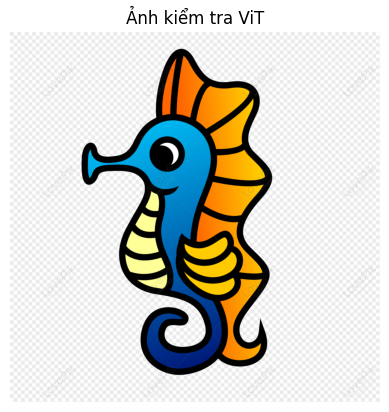

✅ Predicted class: Seahorse


In [ ]:
# Load và kiểm tra mô hình với ảnh mới
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/ViT_Pretrained/test_ViT_img.png'
image = Image.open(image_path).convert("RGB")

# Hiển thị ảnh
plt.imshow(image)
plt.axis("off")
plt.title("Ảnh kiểm tra ViT")
plt.show()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("/content/drive/MyDrive/ViT_Pretrained/sea_animal_cls_model_pth")

# Preprocess ảnh
inputs = feature_extractor(images=image, return_tensors="pt")
sample_image = inputs["pixel_values"].to(device)  # shape: [1, 3, 224, 224]

# Load model
model_path = "/content/drive/MyDrive/ViT_Pretrained/sea_animal_cls_model_pth"
loaded_model = ViTForImageClassification.from_pretrained(model_path)
loaded_model.to(device)
loaded_model.eval()

# Predict
with torch.no_grad():
    outputs = loaded_model(sample_image)
    predicted_class_id = outputs.logits.argmax(-1).item()

# Lấy id2label từ model config
id2label = loaded_model.config.id2label

# Hiển thị kết quả
predicted_class_name = id2label[predicted_class_id]
print(f"✅ Predicted class: {predicted_class_name}")

# Sample_label:
# sample_label = <int>
# true_class_name = id2label[sample_label]
# print(f"✅ True class: {true_class_name}")

In [ ]:
# Giải phóng bộ nhớ GPU (nếu dùng CUDA)
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache has been cleared.")
else:
    print("CUDA is not available.")

CUDA cache has been cleared.
